Running direction ablation on SP-Hamiltonian model (Hamiltonian contexts)...
--- STARTING LAYER-SWEPT DIRECTION ABLATION (N=100 trials, hamiltonian contexts) ---
Generated 100 valid tasks


Sweeping Ablation Layer: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]


Computing baseline accuracy...


Computing baseline: 100%|██████████| 100/100 [00:02<00:00, 36.59it/s]



--- LAYER-SWEPT DIRECTION ABLATION RESULTS ---
Baseline Accuracy (No Ablation): 100.00%
 Ablation Layer  Accuracy
              1      0.07
              2      0.55
              3      0.13
              4      0.56
              5      0.53
              6      0.64
              7      0.66
              8      0.81
              9      0.94
             10      0.86
             11      0.98
             12      0.99


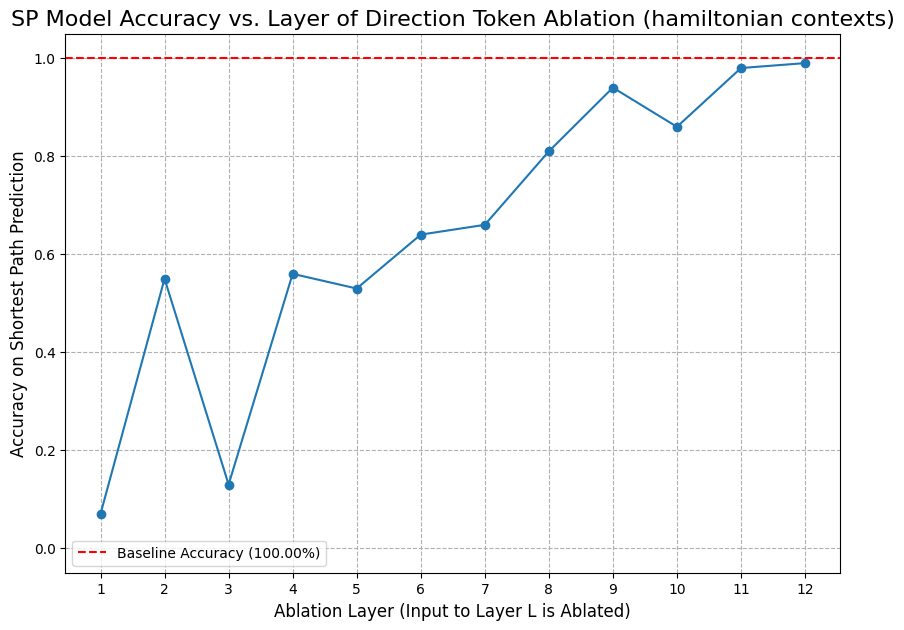


Running direction ablation on SP-Random Walk model (Hamiltonian contexts)...
--- STARTING LAYER-SWEPT DIRECTION ABLATION (N=100 trials, hamiltonian contexts) ---
Generated 100 valid tasks


Sweeping Ablation Layer: 100%|██████████| 12/12 [00:35<00:00,  3.00s/it]


Computing baseline accuracy...


Computing baseline: 100%|██████████| 100/100 [00:03<00:00, 33.14it/s]



--- LAYER-SWEPT DIRECTION ABLATION RESULTS ---
Baseline Accuracy (No Ablation): 96.00%
 Ablation Layer  Accuracy
              1      0.01
              2      0.25
              3      0.37
              4      0.63
              5      0.69
              6      0.48
              7      0.77
              8      0.80
              9      0.83
             10      0.91
             11      0.94
             12      0.96


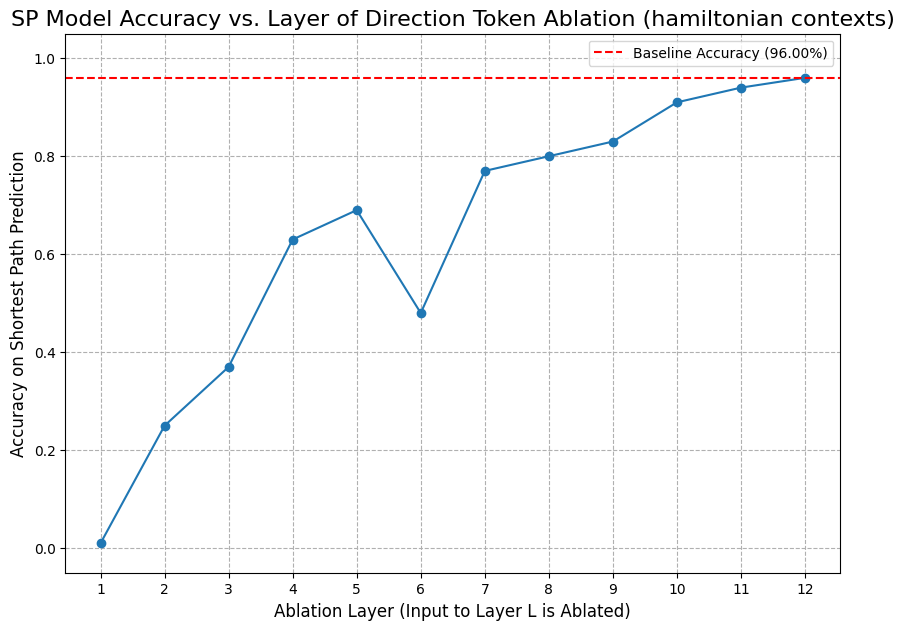

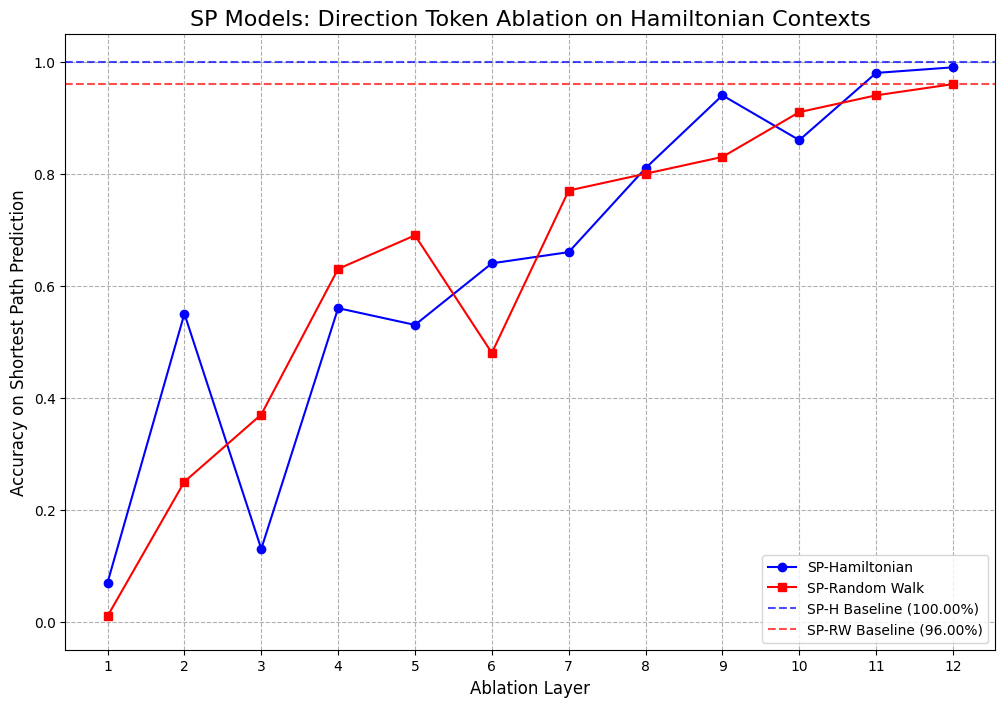

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
import re
import networkx as nx
from tqdm.auto import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

class NavigationGPT:
    def __init__(self, model_path: str):
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None: 
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()

    def generate(self, prompt: str, max_new_tokens: int = 60):
        encodings = self.tokenizer(prompt, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output_ids = self.model.generate(**encodings, max_new_tokens=max_new_tokens, num_beams=1)
        return self.tokenizer.decode(output_ids[0, encodings.input_ids.shape[1]:], skip_special_tokens=True).strip()

def generate_grid_graph(size=4):
    G = nx.DiGraph()
    num_nodes = size * size
    nodes = list(set([''.join(random.choices(string.ascii_lowercase, k=2)) for _ in range(num_nodes*2)]))[:num_nodes]
    node_map = [['' for _ in range(size)] for _ in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            node_map[r][c] = nodes[idx]
            # Add edges
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction='NORTH')
    return G, nodes, node_map

def find_hamiltonian_path(G, max_retries=10):
    for _ in range(max_retries):
        start_node = random.choice(list(G.nodes()))
        path, visited = [start_node], {start_node}
        def search(current):
            if len(path) == len(G.nodes()): return True
            neighbors = list(G.successors(current)); random.shuffle(neighbors)
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor); path.append(neighbor)
                    if search(neighbor): return True
                    path.pop(); visited.remove(neighbor)
            return False
        if search(start_node): return path
    return None

def generate_random_walk(G, length):
    start_node = random.choice(list(G.nodes()))
    path = [start_node]
    for _ in range(length - 1):
        neighbors = list(G.successors(path[-1]))
        if not neighbors: break
        path.append(random.choice(neighbors))
    return path

def walk_to_string(walk, G):
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    return " ".join([f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk)-1)] + [walk[-1]])

def parse_path(text): 
    return re.findall(r'\b[a-z]{2}\b', text)

def is_valid_path(nodes, G): 
    return all(G.has_edge(nodes[i], nodes[i+1]) for i in range(len(nodes)-1))

def score_and_analyze(parsed_nodes, task):
    try:
        all_shortest_paths = list(nx.all_shortest_paths(task['graph'], task['start'], task['end']))
        if not all_shortest_paths: raise nx.NetworkXNoPath
        expected_len = len(all_shortest_paths[0])
    except (nx.NetworkXNoPath, nx.NodeNotFound): 
        all_shortest_paths, expected_len = [], -1
    
    is_path_valid = is_valid_path(parsed_nodes, task['graph'])
    is_correct = is_path_valid and all_shortest_paths and len(parsed_nodes) == expected_len and parsed_nodes in all_shortest_paths
    
    return {
        'accuracy': 1.0 if is_correct else 0.0, 
        'is_valid': is_path_valid,
        'expected_len': expected_len
    }

class PositionalAblationPatcher:
    """Context manager to ablate (zero-out) hidden states at specific token positions."""
    def __init__(self, model, layer_idx, target_positions):
        self.model = model
        self.layer_idx = layer_idx
        self.target_positions = target_positions
        self.hook = None

    def _ablation_hook(self, module, module_input):
        original_hidden_states = module_input[0]
        patched_hidden_states = original_hidden_states.clone()
        for pos in self.target_positions:
            if pos < patched_hidden_states.shape[1]:
                patched_hidden_states[0, pos, :] = 0.0
        return (patched_hidden_states,) + module_input[1:]

    def __enter__(self):
        self.hook = self.model.transformer.h[self.layer_idx].register_forward_pre_hook(self._ablation_hook)

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.hook:
            self.hook.remove()

def create_test_cases(num_tests=100, context_type="hamiltonian"):
    """Create test cases using the working implementation"""
    test_cases = []
    
    for _ in range(num_tests):
        G, nodes, node_map = generate_grid_graph(4)
        
        # Generate context
        if context_type == "hamiltonian":
            context = find_hamiltonian_path(G)
        else:  # random_walk
            context = generate_random_walk(G, 30)
        
        if not context:
            continue
            
        # Choose start and end nodes
        start_node, end_node = random.sample(nodes, 2)
        
        test_cases.append({
            'graph': G, 
            'node_map': node_map, 
            'start': start_node, 
            'end': end_node, 
            'context': context
        })
    
    return test_cases

def get_direction_positions_to_ablate(tokenizer, prompt):
    """Find positions of direction tokens in the context to ablate"""
    tokens = tokenizer(prompt, return_tensors="pt")
    decoded_tokens = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
    
    direction_positions = []
    direction_vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
    in_context = True
    
    for i, token_str in enumerate(decoded_tokens):
        if token_str == "[SEP]":
            in_context = False
        elif in_context and token_str in direction_vocab:
            direction_positions.append(i)
    
    return direction_positions

def run_layer_swept_direction_ablation(model_path, num_trials=100, context_type="hamiltonian"):
    """
    Ablates direction tokens in context at each layer and measures the impact on SP accuracy.
    """
    print(f"--- STARTING LAYER-SWEPT DIRECTION ABLATION (N={num_trials} trials, {context_type} contexts) ---")
    
    # Load model
    model = NavigationGPT(model_path)
    
    # Generate tasks
    tasks = create_test_cases(num_trials, context_type=context_type)
    print(f"Generated {len(tasks)} valid tasks")
    
    num_layers = model.model.config.n_layer
    results_by_layer = []

    # Run ablation sweep
    for layer_to_ablate in tqdm(range(num_layers), desc="Sweeping Ablation Layer"):
        correct_predictions = 0
        display_idx = layer_to_ablate + 1

        for task in tasks:
            # Create prompt
            map_context_str = walk_to_string(task['context'], task['graph'])
            instruction = f"[SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']}"
            prompt = f"[SOS] {map_context_str} [SEP] {instruction} [PLAN]"
            
            # Get direction token positions to ablate
            direction_positions_to_ablate = get_direction_positions_to_ablate(model.tokenizer, prompt)
            
            with PositionalAblationPatcher(model.model, layer_to_ablate, direction_positions_to_ablate):
                # Generate prediction with ablation
                generated_text = model.generate(prompt)
                parsed_nodes = parse_path(generated_text)
                analysis_metrics = score_and_analyze(parsed_nodes, task)
                
                if analysis_metrics['accuracy'] == 1.0:
                    correct_predictions += 1
                
        accuracy = correct_predictions / len(tasks)
        results_by_layer.append({"Ablation Layer": display_idx, "Accuracy": accuracy})

    # Baseline accuracy (no ablation)
    print("Computing baseline accuracy...")
    correct_baseline = 0
    for task in tqdm(tasks, desc="Computing baseline"):
        map_context_str = walk_to_string(task['context'], task['graph'])
        instruction = f"[SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']}"
        prompt = f"[SOS] {map_context_str} [SEP] {instruction} [PLAN]"
        
        generated_text = model.generate(prompt)
        parsed_nodes = parse_path(generated_text)
        analysis_metrics = score_and_analyze(parsed_nodes, task)
        
        if analysis_metrics['accuracy'] == 1.0:
            correct_baseline += 1
    
    baseline_accuracy = correct_baseline / len(tasks)
    
    # Plotting
    summary_df = pd.DataFrame(results_by_layer)
    
    print("\n\n" + "="*80)
    print("--- LAYER-SWEPT DIRECTION ABLATION RESULTS ---")
    print("="*80)
    print(f"Baseline Accuracy (No Ablation): {baseline_accuracy:.2%}")
    print(summary_df.to_string(index=False))

    plt.figure(figsize=(10, 7))
    plt.plot(summary_df['Ablation Layer'], summary_df['Accuracy'], marker='o', linestyle='-')
    plt.axhline(baseline_accuracy, color='r', linestyle='--', label=f'Baseline Accuracy ({baseline_accuracy:.2%})')
    
    plt.title(f'SP Model Accuracy vs. Layer of Direction Token Ablation ({context_type} contexts)', fontsize=16)
    plt.xlabel('Ablation Layer (Input to Layer L is Ablated)', fontsize=12)
    plt.ylabel('Accuracy on Shortest Path Prediction', fontsize=12)
    plt.xticks(range(1, num_layers + 1))
    plt.ylim(-0.05, 1.05)
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.show()
    
    return summary_df, baseline_accuracy

def compare_sp_models_direction_ablation():
    """Compare SP-H vs SP-RW direction ablation results"""
    
    # Model paths
    SPRW = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv3_model_ft/checkpoint-163000"
    SPH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv2_model_fixed/save-checkpoint-46000"
    
    # Run ablation on both models
    print("Running direction ablation on SP-Hamiltonian model...")
    sp_h_results, sp_h_baseline = run_layer_swept_direction_ablation(
        SPH, num_trials=100, context_type="hamiltonian"
    )
    
    print("\nRunning direction ablation on SP-Random Walk model...")
    sp_rw_results, sp_rw_baseline = run_layer_swept_direction_ablation(
        SPRW, num_trials=100, context_type="random_walk"
    )
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    plt.plot(sp_h_results['Ablation Layer'], sp_h_results['Accuracy'], 
             marker='o', linestyle='-', label='SP-Hamiltonian', color='blue')
    plt.plot(sp_rw_results['Ablation Layer'], sp_rw_results['Accuracy'], 
             marker='s', linestyle='-', label='SP-Random Walk', color='red')
    
    plt.axhline(sp_h_baseline, color='blue', linestyle='--', alpha=0.7, label=f'SP-H Baseline ({sp_h_baseline:.2%})')
    plt.axhline(sp_rw_baseline, color='red', linestyle='--', alpha=0.7, label=f'SP-RW Baseline ({sp_rw_baseline:.2%})')
    
    plt.title('SP Models: Direction Token Ablation Comparison', fontsize=16)
    plt.xlabel('Ablation Layer', fontsize=12)
    plt.ylabel('Accuracy on Shortest Path Prediction', fontsize=12)
    plt.xticks(range(1, 13))
    plt.ylim(-0.05, 1.05)
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.show()
    
    return sp_h_results, sp_rw_results


def create_test_cases(num_tests=100, context_type="hamiltonian"):
    """Create test cases using Hamiltonian contexts for both models"""
    test_cases = []
    
    for _ in range(num_tests):
        G, nodes, node_map = generate_grid_graph(4)
        
        # Generate Hamiltonian context (visits all 16 nodes exactly once)
        context = find_hamiltonian_path(G)
        
        if not context:
            continue
            
        # Choose start and end nodes
        start_node, end_node = random.sample(nodes, 2)
        
        test_cases.append({
            'graph': G, 
            'node_map': node_map, 
            'start': start_node, 
            'end': end_node, 
            'context': context
        })
    
    return test_cases

def compare_sp_models_hamiltonian_ablation():
    """Compare SP-H vs SP-RW on Hamiltonian contexts with direction ablation"""
    
    # Model paths
    SPRW = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv3_model_ft/checkpoint-163000"
    SPH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv2_model_fixed/save-checkpoint-46000"
    
    # Run ablation on both models with Hamiltonian contexts
    print("Running direction ablation on SP-Hamiltonian model (Hamiltonian contexts)...")
    sp_h_results, sp_h_baseline = run_layer_swept_direction_ablation(
        SPH, num_trials=100, context_type="hamiltonian"
    )
    
    print("\nRunning direction ablation on SP-Random Walk model (Hamiltonian contexts)...")
    sp_rw_results, sp_rw_baseline = run_layer_swept_direction_ablation(
        SPRW, num_trials=100, context_type="hamiltonian"
    )
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    plt.plot(sp_h_results['Ablation Layer'], sp_h_results['Accuracy'], 
             marker='o', linestyle='-', label='SP-Hamiltonian', color='blue')
    plt.plot(sp_rw_results['Ablation Layer'], sp_rw_results['Accuracy'], 
             marker='s', linestyle='-', label='SP-Random Walk', color='red')
    
    plt.axhline(sp_h_baseline, color='blue', linestyle='--', alpha=0.7, 
                label=f'SP-H Baseline ({sp_h_baseline:.2%})')
    plt.axhline(sp_rw_baseline, color='red', linestyle='--', alpha=0.7, 
                label=f'SP-RW Baseline ({sp_rw_baseline:.2%})')
    
    #plt.title('SP Models: Direction Token Ablation on Hamiltonian Contexts', fontsize=16)
    plt.xlabel('Ablation Layer', fontsize=12)
    plt.ylabel('Accuracy on Shortest Path Prediction', fontsize=12)
    plt.xticks(range(1, 13))
    plt.ylim(-0.05, 1.05)
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.show()
    
    return sp_h_results, sp_rw_results

# Run experiment
if __name__ == "__main__":
    compare_sp_models_hamiltonian_ablation()
# # Run experiment
# if __name__ == "__main__":
#     compare_sp_models_direction_ablation()

In [ ]:
# Layer-Swept Direction Ablation for SP Models on Hamiltonian Contexts
# Tests when direction information becomes redundant in each model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
import re
import networkx as nx
from tqdm.auto import tqdm
import seaborn as sns
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

class NavigationGPT:
    def __init__(self, model_path: str):
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None: 
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()

    def generate(self, prompt: str, max_new_tokens: int = 60):
        encodings = self.tokenizer(prompt, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output_ids = self.model.generate(**encodings, max_new_tokens=max_new_tokens, num_beams=1)
        return self.tokenizer.decode(output_ids[0, encodings.input_ids.shape[1]:], skip_special_tokens=True).strip()

def generate_grid_graph(size=4):
    G = nx.DiGraph()
    num_nodes = size * size
    nodes = list(set([''.join(random.choices(string.ascii_lowercase, k=2)) for _ in range(num_nodes*2)]))[:num_nodes]
    node_map = [['' for _ in range(size)] for _ in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            node_map[r][c] = nodes[idx]
            # Add edges
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction='NORTH')
    return G, nodes, node_map

def find_hamiltonian_path(G, max_retries=10):
    for _ in range(max_retries):
        start_node = random.choice(list(G.nodes()))
        path, visited = [start_node], {start_node}
        def search(current):
            if len(path) == len(G.nodes()): return True
            neighbors = list(G.successors(current)); random.shuffle(neighbors)
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor); path.append(neighbor)
                    if search(neighbor): return True
                    path.pop(); visited.remove(neighbor)
            return False
        if search(start_node): return path
    return None

def walk_to_string(walk, G):
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    return " ".join([f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk)-1)] + [walk[-1]])

def parse_path(text): 
    return re.findall(r'\b[a-z]{2}\b', text)

def is_valid_path(nodes, G): 
    return all(G.has_edge(nodes[i], nodes[i+1]) for i in range(len(nodes)-1))

def score_and_analyze(parsed_nodes, task):
    try:
        all_shortest_paths = list(nx.all_shortest_paths(task['graph'], task['start'], task['end']))
        if not all_shortest_paths: raise nx.NetworkXNoPath
        expected_len = len(all_shortest_paths[0])
    except (nx.NetworkXNoPath, nx.NodeNotFound): 
        all_shortest_paths, expected_len = [], -1
    
    is_path_valid = is_valid_path(parsed_nodes, task['graph'])
    is_correct = is_path_valid and all_shortest_paths and len(parsed_nodes) == expected_len and parsed_nodes in all_shortest_paths
    
    return {
        'accuracy': 1.0 if is_correct else 0.0, 
        'is_valid': is_path_valid,
        'expected_len': expected_len
    }

class PositionalAblationPatcher:
    """Context manager to ablate (zero-out) hidden states at specific token positions."""
    def __init__(self, model, layer_idx, target_positions):
        self.model = model
        self.layer_idx = layer_idx
        self.target_positions = target_positions
        self.hook = None

    def _ablation_hook(self, module, module_input):
        original_hidden_states = module_input[0]
        patched_hidden_states = original_hidden_states.clone()
        for pos in self.target_positions:
            if pos < patched_hidden_states.shape[1]:
                patched_hidden_states[0, pos, :] = 0.0
        return (patched_hidden_states,) + module_input[1:]

    def __enter__(self):
        self.hook = self.model.transformer.h[self.layer_idx].register_forward_pre_hook(self._ablation_hook)

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.hook:
            self.hook.remove()

def create_test_cases(num_tests=100):
    """Create test cases using Hamiltonian contexts for both models"""
    test_cases = []
    
    for _ in range(num_tests):
        G, nodes, node_map = generate_grid_graph(4)
        
        # Generate Hamiltonian context (visits all 16 nodes exactly once)
        context = find_hamiltonian_path(G)
        
        if not context:
            continue
            
        # Choose start and end nodes
        start_node, end_node = random.sample(nodes, 2)
        
        test_cases.append({
            'graph': G, 
            'node_map': node_map, 
            'start': start_node, 
            'end': end_node, 
            'context': context
        })
    
    return test_cases

def get_direction_positions_to_ablate(tokenizer, prompt):
    """Find positions of direction tokens in the context to ablate"""
    tokens = tokenizer(prompt, return_tensors="pt")
    decoded_tokens = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
    
    direction_positions = []
    direction_vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
    in_context = True
    
    for i, token_str in enumerate(decoded_tokens):
        if token_str == "[SEP]":
            in_context = False
        elif in_context and token_str in direction_vocab:
            direction_positions.append(i)
    
    return direction_positions

def run_layer_swept_direction_ablation(model_path, num_trials=100):
    """
    Ablates direction tokens in context at each layer and measures the impact on SP accuracy.
    """
    print(f"--- STARTING LAYER-SWEPT DIRECTION ABLATION (N={num_trials} trials, Hamiltonian contexts) ---")
    
    # Load model
    model = NavigationGPT(model_path)
    
    # Generate tasks
    tasks = create_test_cases(num_trials)
    print(f"Generated {len(tasks)} valid tasks")
    
    num_layers = model.model.config.n_layer
    results_by_layer = []

    # Run ablation sweep
    for layer_to_ablate in tqdm(range(num_layers), desc="Sweeping Ablation Layer"):
        correct_predictions = 0
        display_idx = layer_to_ablate + 1

        for task in tasks:
            # Create prompt
            map_context_str = walk_to_string(task['context'], task['graph'])
            instruction = f"[SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']}"
            prompt = f"[SOS] {map_context_str} [SEP] {instruction} [PLAN]"
            
            # Get direction token positions to ablate
            direction_positions_to_ablate = get_direction_positions_to_ablate(model.tokenizer, prompt)
            
            with PositionalAblationPatcher(model.model, layer_to_ablate, direction_positions_to_ablate):
                # Generate prediction with ablation
                generated_text = model.generate(prompt)
                parsed_nodes = parse_path(generated_text)
                analysis_metrics = score_and_analyze(parsed_nodes, task)
                
                if analysis_metrics['accuracy'] == 1.0:
                    correct_predictions += 1
                
        accuracy = correct_predictions / len(tasks)
        results_by_layer.append(accuracy)

    # Baseline accuracy (no ablation)
    print("Computing baseline accuracy...")
    correct_baseline = 0
    for task in tqdm(tasks, desc="Computing baseline"):
        map_context_str = walk_to_string(task['context'], task['graph'])
        instruction = f"[SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']}"
        prompt = f"[SOS] {map_context_str} [SEP] {instruction} [PLAN]"
        
        generated_text = model.generate(prompt)
        parsed_nodes = parse_path(generated_text)
        analysis_metrics = score_and_analyze(parsed_nodes, task)
        
        if analysis_metrics['accuracy'] == 1.0:
            correct_baseline += 1
    
    baseline_accuracy = correct_baseline / len(tasks)
    
    return results_by_layer, baseline_accuracy

def compare_sp_models_hamiltonian_ablation():
    """Compare SP-H vs SP-RW on Hamiltonian contexts with direction ablation"""
    
    # Model paths
    SPRW = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv3_model_ft/checkpoint-163000"
    SPH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv2_model_fixed/save-checkpoint-46000"
    
    # Run ablation on both models with Hamiltonian contexts
    print("Running direction ablation on SP-Hamiltonian model (Hamiltonian contexts)...")
    sp_h_results, sp_h_baseline = run_layer_swept_direction_ablation(SPH, num_trials=1000)
    
    print("\nRunning direction ablation on SP-Random Walk model (Hamiltonian contexts)...")
    sp_rw_results, sp_rw_baseline = run_layer_swept_direction_ablation(SPRW, num_trials=1000)
    
    # --- Plotting style consistent with other figures ---
    plt.rcParams.update({
        "axes.edgecolor": "black",
        "axes.linewidth": 2,
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "xtick.major.width": 2,
        "ytick.major.width": 2,
        "xtick.major.size": 7,
        "ytick.major.size": 7,
    })
    sns.set_theme(style="ticks", context="talk", rc={
        "axes.edgecolor": "black",
        "axes.labelcolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
    })
    
    # --- Convert results to arrays for plotting ---
    num_layers = 12
    layers = np.arange(1, num_layers + 1)
    
    # Calculate confidence intervals
    sp_h_acc = np.array(sp_h_results)
    sp_rw_acc = np.array(sp_rw_results)
    
    sp_h_ci = 1.96 * np.sqrt(sp_h_acc * (1 - sp_h_acc) / 1000)  # 95% CI for proportion
    sp_rw_ci = 1.96 * np.sqrt(sp_rw_acc * (1 - sp_rw_acc) / 1000)
    
    # --- Plot ---
    plt.figure(figsize=(12, 8))
    
    # SP-Hamiltonian curve
    plt.plot(layers, sp_h_acc, marker='o', linestyle='-', color='#436175', 
             label='SP-Hamiltonian', linewidth=2, markersize=6)
    plt.fill_between(layers, sp_h_acc - sp_h_ci, sp_h_acc + sp_h_ci, 
                     color='#436175', alpha=0.2, label='_nolegend_')
    
    # SP-Random Walk curve
    plt.plot(layers, sp_rw_acc, marker='s', linestyle='-', color='#8B4513', 
             label='SP-Random Walk', linewidth=2, markersize=6)
    plt.fill_between(layers, sp_rw_acc - sp_rw_ci, sp_rw_acc + sp_rw_ci, 
                     color='#8B4513', alpha=0.2, label='_nolegend_')
    
    # Baseline lines
    plt.axhline(sp_h_baseline, color='#436175', linestyle='--', alpha=0.7, 
                label=f'SP-H Baseline ({sp_h_baseline:.2%})')
    plt.axhline(sp_rw_baseline, color='#8B4513', linestyle='--', alpha=0.7, 
                label=f'SP-RW Baseline ({sp_rw_baseline:.2%})')
    
    plt.xlabel('Ablation Layer (Input to Layer L is Ablated)', fontsize=15, fontweight="heavy")
    plt.ylabel('Accuracy (Shortest Path Prediction)', fontsize=15, fontweight="heavy")
    #plt.title('SP Models: Direction Token Ablation on Hamiltonian Contexts', fontsize=16, fontweight="heavy")
    plt.xticks(range(1, num_layers + 1))
    plt.yticks(np.linspace(0, 1, 5))
    sns.despine()
    plt.ylim(-0.05, 1.05)
    plt.grid(False)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\n" + "="*80)
    print("--- LAYER-SWEPT DIRECTION ABLATION RESULTS ---")
    print("="*80)
    print(f"SP-Hamiltonian Baseline Accuracy: {sp_h_baseline:.2%}")
    print(f"SP-Random Walk Baseline Accuracy: {sp_rw_baseline:.2%}")
    print("\nLayer-by-Layer Results:")
    for i, (h_acc, rw_acc) in enumerate(zip(sp_h_results, sp_rw_results)):
        print(f"Layer {i+1:2d}: SP-H = {h_acc:.2%}, SP-RW = {rw_acc:.2%}")
    
    return sp_h_results, sp_rw_results

# Run experiment
if __name__ == "__main__":
    compare_sp_models_hamiltonian_ablation()

Running direction ablation on SP-Hamiltonian model (Hamiltonian contexts)...
--- STARTING LAYER-SWEPT DIRECTION ABLATION (N=1000 trials, Hamiltonian contexts) ---
Generated 1000 valid tasks


Sweeping Ablation Layer: 100%|██████████| 12/12 [05:50<00:00, 29.24s/it]


Computing baseline accuracy...


Computing baseline: 100%|██████████| 1000/1000 [00:28<00:00, 35.48it/s]



Running direction ablation on SP-Random Walk model (Hamiltonian contexts)...
--- STARTING LAYER-SWEPT DIRECTION ABLATION (N=1000 trials, Hamiltonian contexts) ---
Generated 1000 valid tasks


Sweeping Ablation Layer:   8%|▊         | 1/12 [00:31<05:46, 31.50s/it]

/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Generating a shared set of test cases for all experiments ---


Generating test cases: 100%|██████████| 500/500 [00:00<00:00, 4381.57it/s]


--- TESTING MODEL: SP-Hamiltonian ---


Computing baseline accuracy...


Sweeping Ablation (east_west): 100%|██████████| 12/12 [03:36<00:00, 18.03s/it]


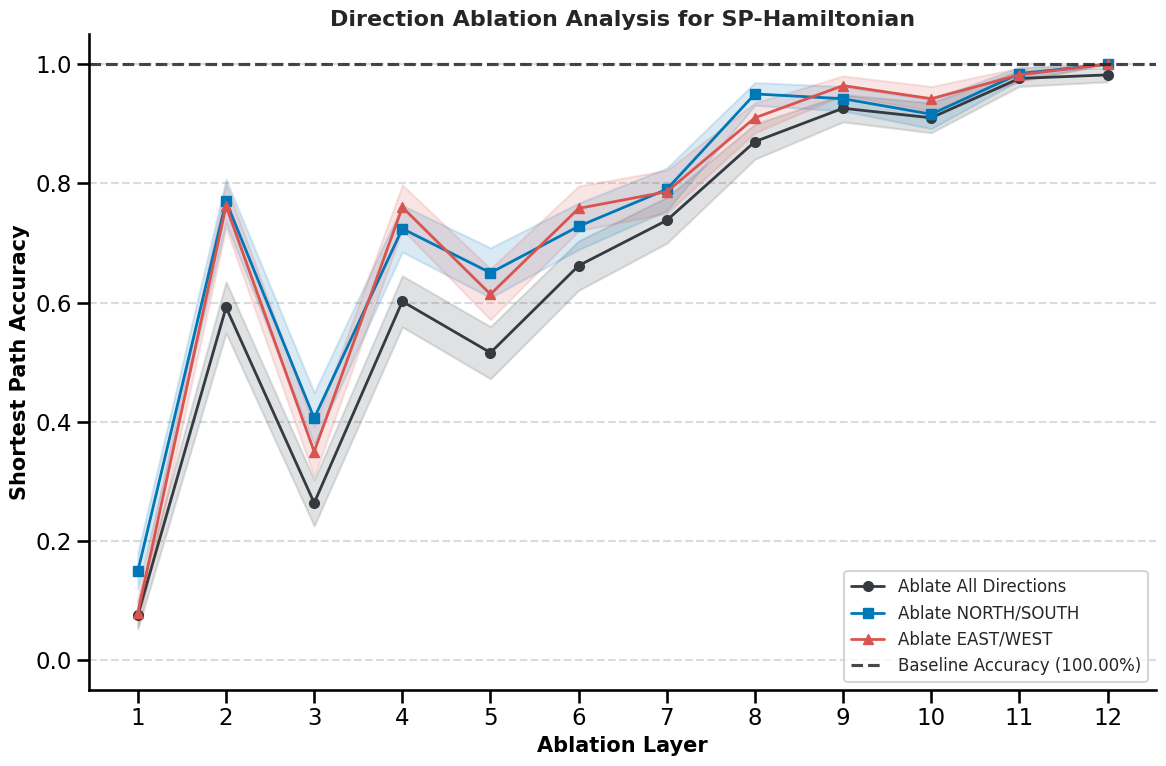


--- TESTING MODEL: SP-Random Walk ---
Computing baseline accuracy...


Sweeping Ablation (east_west): 100%|██████████| 12/12 [03:09<00:00, 15.81s/it]


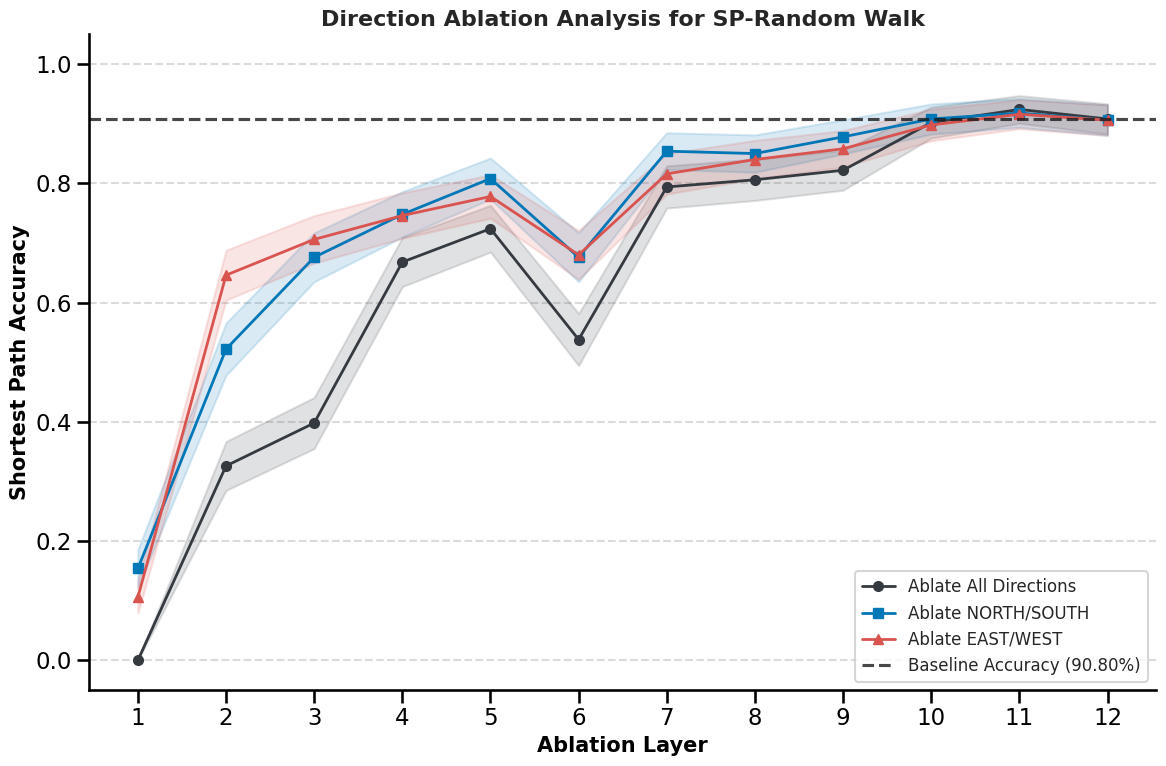


--- FINAL ABLATION RESULTS SUMMARY ---
Baselines: SP-Hamiltonian  baseline    1.000
SP-Random Walk  baseline    0.908

Layer-wise Accuracy:
         SP-Hamiltonian                       SP-Random Walk              \
                    all north_south east_west            all north_south   
Layer 1           7.60%      15.00%     8.00%          0.00%      15.40%   
Layer 2          59.20%      77.00%    76.20%         32.60%      52.20%   
Layer 3          26.40%      40.60%    35.00%         39.80%      67.60%   
Layer 4          60.20%      72.40%    76.00%         66.80%      74.80%   
Layer 5          51.60%      65.00%    61.40%         72.40%      80.80%   
Layer 6          66.20%      72.80%    75.80%         53.80%      67.60%   
Layer 7          73.80%      79.00%    78.60%         79.40%      85.40%   
Layer 8          87.00%      95.00%    91.00%         80.60%      85.00%   
Layer 9          92.60%      94.20%    96.40%         82.20%      87.80%   
Layer 10         91.00%

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
import re
import networkx as nx
from tqdm.auto import tqdm
import seaborn as sns
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

class NavigationGPT:
    def __init__(self, model_path: str):
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None: 
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()

    def generate(self, prompt: str, max_new_tokens: int = 25): # Reduced max tokens for efficiency
        encodings = self.tokenizer(prompt, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output_ids = self.model.generate(**encodings, max_new_tokens=max_new_tokens, num_beams=1)
        return self.tokenizer.decode(output_ids[0, encodings.input_ids.shape[1]:], skip_special_tokens=True).strip()

def generate_grid_graph(size=4):
    G = nx.DiGraph()
    nodes = [f"{chr(97+i)}{chr(97+j)}" for i in range(26) for j in range(26)][:size*size]
    node_map = [['' for _ in range(size)] for _ in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            node_map[r][c] = nodes[idx]
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+(r*size+c+1)-(r*size+c)], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction='NORTH')
    return G, nodes, node_map

def find_hamiltonian_path(G, max_retries=10):
    nodes = list(G.nodes())
    for _ in range(max_retries):
        start_node = random.choice(nodes)
        path, visited = [start_node], {start_node}
        def search(current):
            if len(path) == len(nodes): return True
            neighbors = list(G.successors(current)); random.shuffle(neighbors)
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor); path.append(neighbor)
                    if search(neighbor): return True
                    path.pop(); visited.remove(neighbor)
            return False
        if search(start_node): return path
    return None

def walk_to_string(walk, G):
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    return " ".join([f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk)-1)] + [walk[-1]])

def parse_path(text): return re.findall(r'\b[a-z]{2}\b', text)
def is_valid_path(nodes, G): return all(G.has_edge(nodes[i], nodes[i+1]) for i in range(len(nodes)-1))

def score_and_analyze(parsed_nodes, task):
    try:
        all_shortest = list(nx.all_shortest_paths(task['graph'], task['start'], task['end']))
        expected_len = len(all_shortest[0])
    except (nx.NetworkXNoPath, nx.NodeNotFound): return {'accuracy': 0.0}
    is_correct = is_valid_path(parsed_nodes, task['graph']) and len(parsed_nodes) == expected_len and parsed_nodes in all_shortest
    return {'accuracy': 1.0 if is_correct else 0.0}

class PositionalAblationPatcher:
    def __init__(self, model, layer_idx, target_positions):
        self.model, self.layer_idx, self.target_positions, self.hook = model, layer_idx, target_positions, None
    def _ablation_hook(self, module, module_input):
        patched_states = module_input[0].clone()
        for pos in self.target_positions:
            if pos < patched_states.shape[1]: patched_states[0, pos, :] = 0.0
        return (patched_states,) + module_input[1:]
    def __enter__(self): self.hook = self.model.transformer.h[self.layer_idx].register_forward_pre_hook(self._ablation_hook)
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.hook: self.hook.remove()

def create_test_cases(num_tests=100):
    test_cases = []
    pbar = tqdm(total=num_tests, desc="Generating test cases")
    while len(test_cases) < num_tests:
        G, nodes, _ = generate_grid_graph(4)
        context = find_hamiltonian_path(G)
        if not context: continue
        start, end = random.sample(nodes, 2)
        if not nx.has_path(G, start, end): continue
        test_cases.append({'graph': G, 'start': start, 'end': end, 'context': context})
        pbar.update(1)
    pbar.close()
    return test_cases

# --- MODIFIED: Function now accepts an ablation_type ---
def get_direction_positions_to_ablate(tokenizer, prompt, ablation_type: str):
    if ablation_type == 'north_south':
        vocab = {"NORTH", "SOUTH"}
    elif ablation_type == 'east_west':
        vocab = {"EAST", "WEST"}
    elif ablation_type == 'all':
        vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
    else:
        raise ValueError("Invalid ablation_type specified.")
        
    tokens = tokenizer(prompt, return_tensors="pt")
    decoded = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
    positions, in_context = [], True
    for i, token_str in enumerate(decoded):
        if token_str == "[SEP]": in_context = False
        elif in_context and token_str in vocab: positions.append(i)
    return positions

# --- MODIFIED: Function now accepts an ablation_type ---
def run_layer_swept_direction_ablation(model, tasks, ablation_type: str):
    num_layers = model.model.config.n_layer
    results_by_layer = []
    
    for layer in tqdm(range(num_layers), desc=f"Sweeping Ablation ({ablation_type})"):
        correct = 0
        for task in tasks:
            map_str = walk_to_string(task['context'], task['graph'])
            prompt = f"[SOS] {map_str} [SEP] [SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']} [PLAN]"
            positions = get_direction_positions_to_ablate(model.tokenizer, prompt, ablation_type)
            with PositionalAblationPatcher(model.model, layer, positions):
                generated = model.generate(prompt)
                parsed = parse_path(generated)
                if score_and_analyze(parsed, task)['accuracy'] == 1.0:
                    correct += 1
        results_by_layer.append(correct / len(tasks))
    return results_by_layer

# --- NEW: Plotting function for a single model with multiple ablation types ---
def plot_model_ablation_results(results_dict, baseline, model_name, num_trials):
    plt.figure(figsize=(12, 8))
    sns.set_theme(style="ticks", context="talk", rc={"axes.edgecolor": "black", "axes.labelcolor": "black", "xtick.color": "black", "ytick.color": "black"})
    num_layers = len(next(iter(results_dict.values())))
    layers = np.arange(1, num_layers + 1)
    colors = {'all': '#343a40', 'north_south': '#0077b6', 'east_west': '#d9534f'}
    markers = {'all': 'o', 'north_south': 's', 'east_west': '^'}
    labels = {'all': 'Ablate All Directions', 'north_south': 'Ablate NORTH/SOUTH', 'east_west': 'Ablate EAST/WEST'}

    for key, results in results_dict.items():
        acc = np.array(results)
        ci = 1.96 * np.sqrt(acc * (1 - acc) / num_trials)
        plt.plot(layers, acc, marker=markers[key], linestyle='-', color=colors[key], label=labels[key], linewidth=2, markersize=7)
        plt.fill_between(layers, acc - ci, acc + ci, color=colors[key], alpha=0.15)

    plt.axhline(baseline, color='k', linestyle='--', alpha=0.8, label=f'Baseline Accuracy ({baseline:.2%})')
    plt.xlabel('Ablation Layer', fontsize=15, fontweight="heavy")
    plt.ylabel('Shortest Path Accuracy', fontsize=15, fontweight="heavy")
    plt.title(f'Direction Ablation Analysis for {model_name}', fontsize=16, fontweight="heavy")
    plt.xticks(range(1, num_layers + 1)); plt.yticks(np.linspace(0, 1, 6))
    sns.despine(); plt.ylim(-0.05, 1.05); plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12); plt.tight_layout(); plt.show()

# --- RESTRUCTURED: Main function to orchestrate the full experiment ---
def run_full_experiment():
    SPRW_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv3_model_ft/checkpoint-163000"
    SPH_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv2_model_fixed/save-checkpoint-46000"
    NUM_TRIALS = 500 # Adjust as needed for speed/accuracy trade-off
    ABLATION_TYPES = ['all', 'north_south', 'east_west']
    
    models_to_test = {'SP-Hamiltonian': SPH_PATH, 'SP-Random Walk': SPRW_PATH}
    all_results = {}

    print("--- Generating a shared set of test cases for all experiments ---")
    shared_tasks = create_test_cases(NUM_TRIALS)

    for model_name, model_path in models_to_test.items():
        print(f"\n{'='*80}\n--- TESTING MODEL: {model_name} ---\n{'='*80}")
        model = NavigationGPT(model_path)
        results_for_model = {}
        
        # Calculate baseline once
        print("Computing baseline accuracy...")
        correct_baseline = 0
        for task in tqdm(shared_tasks, desc="Baseline"):
            map_str = walk_to_string(task['context'], task['graph'])
            prompt = f"[SOS] {map_str} [SEP] [SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']} [PLAN]"
            generated = model.generate(prompt)
            if score_and_analyze(parse_path(generated), task)['accuracy'] == 1.0:
                correct_baseline += 1
        baseline = correct_baseline / len(shared_tasks)
        
        # Run ablation for each condition
        for ab_type in ABLATION_TYPES:
            results = run_layer_swept_direction_ablation(model, shared_tasks, ab_type)
            results_for_model[ab_type] = results
        
        all_results[model_name] = {'baseline': baseline, 'results': results_for_model}
        plot_model_ablation_results(results_for_model, baseline, model_name, NUM_TRIALS)
    
    # Print final summary table
    print("\n" + "="*80)
    print("--- FINAL ABLATION RESULTS SUMMARY ---")
    print("="*80)
    df = pd.DataFrame({
        (model, ab_type): res['results'][ab_type]
        for model, res in all_results.items()
        for ab_type in ABLATION_TYPES
    })
    df.index = [f"Layer {i+1}" for i in df.index]
    baselines = pd.Series({(model, 'baseline'): res['baseline'] for model, res in all_results.items()})
    print("Baselines:", baselines.to_string())
    print("\nLayer-wise Accuracy:")
    pd.set_option('display.float_format', '{:.2%}'.format)
    print(df)

if __name__ == "__main__":
    run_full_experiment()